In [416]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [290]:
dfm = pd.read_csv('../code/target_metrics.tsv', sep=' +', engine='python').set_index('method')
dfm

,ARI_fi,ARI_ru,ARI_de,F1_fi,F1_ru,F1_de
method,,,,,,
AggloM,0.581,0.026,0.492,0.674,0.643,0.695
AggloM_FiEnRu,0.631,0.037,0.485,0.731,0.636,0.639
WSD_GR,0.581,0.041,0.386,0.690,0.721,0.694
WSD_GR_FiEnRu,0.649,0.048,0.521,0.756,0.750,0.745
WSD_GR_Ru,0.568,0.053,0.464,0.568,0.750,0.724
WSD_GR_Fi_SG,0.638,0.059,0.543,0.752,0.729,0.758
WSI_agglomerative,0.209,0.259,0.316,0.055,0.152,0.042
cluster2sense,0.209,0.259,0.316,0.392,0.346,0.432
outlier2cluster_fi,0.649,0.047,0.480,0.756,0.747,0.745


In [291]:
# take outlier2cluster_ru for Russian, outerlier2cluster_fi for Finnish and German
dfm.loc['outlier2cluster'] = dfm.loc["outlier2cluster_ru"].where(dfm.columns.str.endswith('ru'), 
                                                                dfm.loc["outlier2cluster_fi"])
# Rename methods we want to plot to not contain '_'
dfm = dfm.rename(index={'WSD_GR':'WSD','WSD_GR_FiEnRu':'WSD ft.','WSI_agglomerative':'WSI'})
# Drop methods we do not want to plot
dfm = dfm.loc[~dfm.index.str.contains('_')]
dfm = dfm.drop(['cluster2sense','AggloM'])

In [314]:
dfmb = pd.read_csv('wsdbaselines.scores.tsv', sep='\t').set_index('method')
dfmb = dfmb.query('part=="test"')
dfmb = dfmb.drop(columns=['part'])
dfmb.columns = [c.split('-')[1] + '_' + c.split('-')[0][:2].replace('ge','de') for c in dfmb.columns]
dfmb

,ARI_fi,ARI_de,ARI_ru,F1_fi,F1_de,F1_ru
method,,,,,,
mfs_old_sense,0.596+-0.000 (100),0.125+-0.000 (100),0.005+-0.000 (100),0.654+-0.005 (100),0.347+-0.021 (100),0.577+-0.015 (100)
random_old_sense,0.522+-0.007 (100),0.044+-0.010 (100),0.004+-0.010 (100),0.621+-0.007 (100),0.401+-0.018 (100),0.577+-0.012 (100)


In [315]:
dfmo = pd.read_csv('others_metrics.tsv', sep=' ').set_index('method')
dfmb = pd.concat([dfmb,dfmo.query('method=="Baseline official"')])
dfmb

,ARI_fi,ARI_de,ARI_ru,F1_fi,F1_de,F1_ru
method,,,,,,
mfs_old_sense,0.596+-0.000 (100),0.125+-0.000 (100),0.005+-0.000 (100),0.654+-0.005 (100),0.347+-0.021 (100),0.577+-0.015 (100)
random_old_sense,0.522+-0.007 (100),0.044+-0.010 (100),0.004+-0.010 (100),0.621+-0.007 (100),0.401+-0.018 (100),0.577+-0.012 (100)
Baseline official,0.023,0.022,0.079,0.23,0.13,0.26


In [437]:
dfmb = dfmb.rename(index={
    'Baseline official':'official', 'mfs_old_sense': 'MFS of old uses', 'random_old_sense': 'random old sense'})

,ARI_fi,ARI_de,ARI_ru,F1_fi,F1_de,F1_ru
method,,,,,,
MFS of old uses,0.596+-0.000 (100),0.125+-0.000 (100),0.005+-0.000 (100),0.654+-0.005 (100),0.347+-0.021 (100),0.577+-0.015 (100)
random old sense,0.522+-0.007 (100),0.044+-0.010 (100),0.004+-0.010 (100),0.621+-0.007 (100),0.401+-0.018 (100),0.577+-0.012 (100)
official,0.023,0.022,0.079,0.23,0.13,0.26


In [316]:
dfmo = dfmo.drop('Baseline official')
dfmo.index = dfmo.index.str.replace('^.*$','other teams', regex=True)
dfmo

,ARI_fi,ARI_ru,ARI_de,F1_fi,F1_ru,F1_de
method,,,,,,
other teams,0.596,0.043,0.298,0.655,0.661,0.608
other teams,0.437,0.098,0.396,0.550,0.640,0.580
other teams,0.548,0.000,0.314,0.590,0.570,0.300
other teams,0.553,0.009,0.102,0.655,0.000,0.638
other teams,0.428,0.132,0.000,0.503,0.446,0.000


In [438]:
from collections import defaultdict
baseline_metrics = defaultdict(dict)

for method, row in dfmb.iterrows():
    for colname,v in row.items():
        if colname=='part': continue
        if isinstance(v, str):
            mean, std = tuple(map(float,v.split(' ')[0].split('+-')))
            baseline_metrics[colname][method] = (mean, std)
        else:
            baseline_metrics[colname][method] = (v, 0)

In [439]:
pdf = pd.concat([dfmo, dfm])
pdf = pdf.reset_index().melt(id_vars=['method'], var_name='metric')
pdf[['metric','part']] = pdf.metric.str.split('_', expand=True)

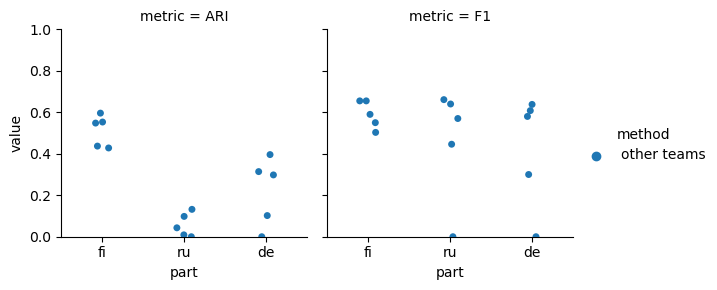

In [319]:
g = sns.catplot(data=pdf.query('method=="other teams"'), x='part', y='value', col='metric', hue='method', height=3)
g.set(ylim=(0.0,1.0))

In [461]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

baseline2style = {'official':'solid', 'MFS of old uses':'dashed', 'random old sense':'dotted'}
legend_elements = {method: Line2D([0], [0], color='grey', lw=2, label=method, linestyle=style) 
                   for method,style in baseline2style.items()}

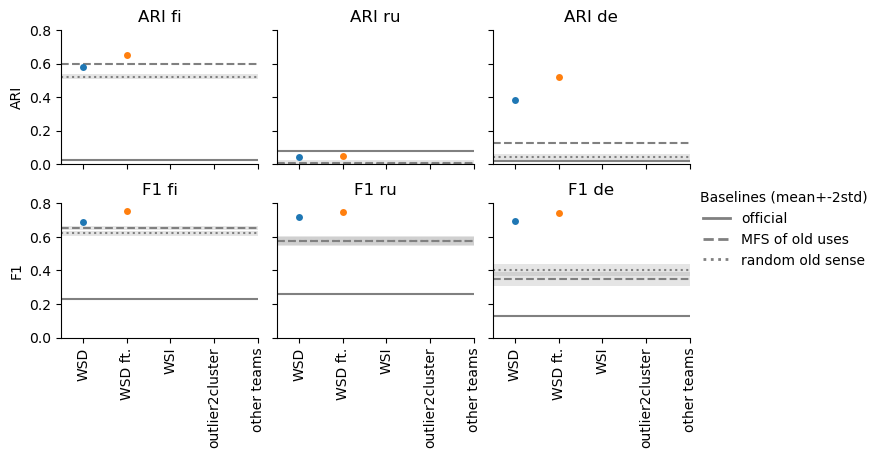

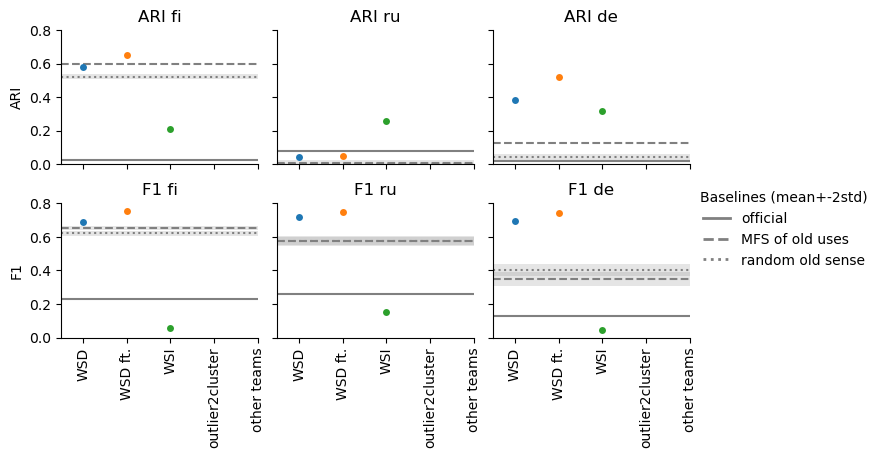

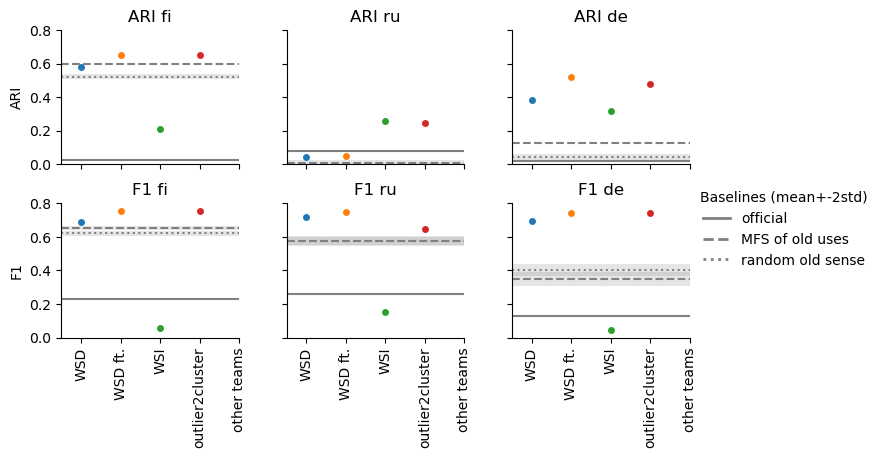

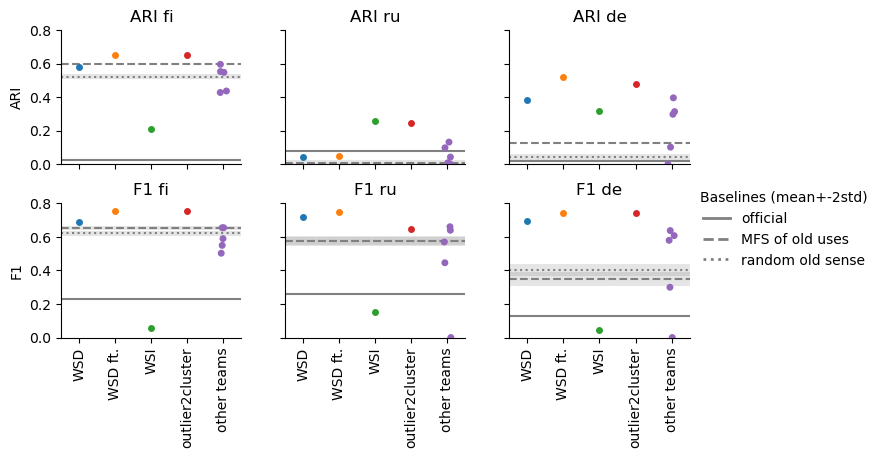

In [474]:
order = ['WSD','WSD ft.', 'WSI', 'outlier2cluster','other teams']
for i in [2,3,4,5]:
    
    plotdf = pd.concat([pdf[pdf.method==m] for m in order[:i]])
    g = sns.catplot(data=plotdf, x='method', y='value', row='metric', col='part', hue='method',
                    legend_out=True, legend=True, height=2, aspect=1.2)
    g.tick_params(axis='x', which='both', rotation=90)
    for mp, ax in g.axes_dict.items():
        ax.set_xticks(order) 
        ax.set_ylabel(mp[0])
        ax.set_title(' '.join(mp))
        mp = '_'.join(mp)
        for method, v in baseline_metrics[mp].items():
            mean, std = v
            ax.axhline(mean, linestyle=baseline2style[method], 
                       color='grey')
            ax.axhspan(mean-2*std, mean+2*std, facecolor='grey', alpha=0.2)
            
    g.set(xlabel=None, ylim=(0.0,0.8))
    g.add_legend(legend_elements, title='Baselines (mean+-2std)')
#     plt.show()